# User Settings

In [6]:
"""
Alle Daten können nicht analysiert werden:
    MemoryError: Unable to allocate 72.7 GiB for an array with shape (98777, 98777) and data type float64
Daher wurde sich für ein Sampling entschieden.
"""
# --- Sampling-Parameter ---
sample_frac = 0.1   # 10 % der Daten pro Stichprobe
n_runs      = 5    # 20 unabhängige Stichprobenläufe
seed        = 42     # Basis-Seed für Reproduzierbarkeit


save_data = False

# 1. Datengrundlage
## 1.1 Import

In [7]:
import pandas as pd
from pathlib import Path
from datetime import datetime

current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
data_path = Path("../../data/")

file_real = data_path / "20250301_data_20250421_133906_final_10_train.csv"
df_real = pd.read_csv(file_real, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_real = Path(file_real)
# print(df_real.head())

file_synth = data_path / "20250301_data_20250421_133906_final_synth_10_epochs.csv"
df_synth = pd.read_csv(file_synth, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_synth = Path(file_synth)
# print(df_synth.head())

file_holdout = data_path / "20250301_data_20250421_133906_final_10_holdout.csv"
df_holdout = pd.read_csv(file_holdout, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_holdout = Path(file_holdout)

In [8]:
numerical_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
categorical_cols = ['icu_admission_24h', 'gender', 'ethnicity', 'consciousness_level','news_score', 'night_arrival', 'weekend_arrival','chief_complaint', 'icd_block']

# 2. Funktion

In [9]:
from syntheval import SynthEval
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# --- 1) Szenarien mit Konstruktor-Funktionen definieren ---
scenarios = {
    'real': {
        'constructor': lambda df_r, df_h: SynthEval(
            real_dataframe=df_r,
            cat_cols=categorical_cols,
            verbose=False
        ),
        'metrics': ['eps_identif_risk']
    },
    'holdout': {
        'constructor': lambda df_r, df_h: SynthEval(
            real_dataframe=df_r,
            holdout_dataframe=df_h,
            cat_cols=categorical_cols,
            verbose=False
        ),
        'metrics': ['eps_identif_risk', 'priv_loss_eps']
    },
}

# --- 2) Sampling + Evaluate + Aggregation mit reproducible random_state ---
def sample_evaluate(constructor, df_real, df_synth, df_holdout, metrics,
                    sample_frac, n_runs, seed):
    vals = {m: [] for m in metrics}
    errs = {m: [] for m in metrics}

    for run_idx in tqdm(range(n_runs), desc="Sampling runs", leave=False):
        rs = seed + run_idx
        # sowohl real-, synth- als auch holdout-DataFrame stichprobenartig verkleinern
        df_r_samp = df_real.sample(frac=sample_frac, replace=False, random_state=rs)
        df_s_samp = df_synth.sample(frac=sample_frac, replace=False, random_state=rs)
        df_h_samp = (df_holdout.sample(frac=sample_frac, replace=False, random_state=rs)
                     if df_holdout is not None else None)

        # neuen Evaluator mit gesampelten Daten erzeugen
        evaluator = constructor(df_r_samp, df_h_samp)
        df_eval   = evaluator.evaluate(df_s_samp, eps_risk={}).set_index('metric')

        for m in metrics:
            if m in df_eval.index:
                row = df_eval.loc[m]
                vals[m].append(row['val'])
                errs[m].append(row['err'])
            else:
                vals[m].append(np.nan)
                errs[m].append(np.nan)

    # Aggregation: Mittelwert der vals, Standardfehler des Mittels
    agg = {}
    for m in metrics:
        arr = np.array(vals[m])
        agg[f'{m}_val'] = arr.mean()
        agg[f'{m}_err'] = arr.std(ddof=1) / np.sqrt(len(arr))
    return agg

# --- 3) Runs über alle Szenarien ---
records = []
for name, cfg in tqdm(scenarios.items(), desc="Scenarios"):
    agg = sample_evaluate(
        cfg['constructor'],
        df_real,
        df_synth,
        df_holdout if name == 'holdout' else None,
        cfg['metrics'],
        sample_frac,
        n_runs,
        seed
    )
    rec = {'scenario': name}
    rec.update(agg)
    records.append(rec)

# --- 4) Ergebnis-DataFrame ---
df_results = pd.DataFrame(records)
print(df_results)

Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling runs:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling runs:   0%|          | 0/5 [00:00<?, ?it/s]

  scenario  eps_identif_risk_val  eps_identif_risk_err  priv_loss_eps_val  \
0     real              0.250456              0.003761                NaN   
1  holdout              0.250253              0.003046           0.072505   

   priv_loss_eps_err  
0                NaN  
1           0.002542  


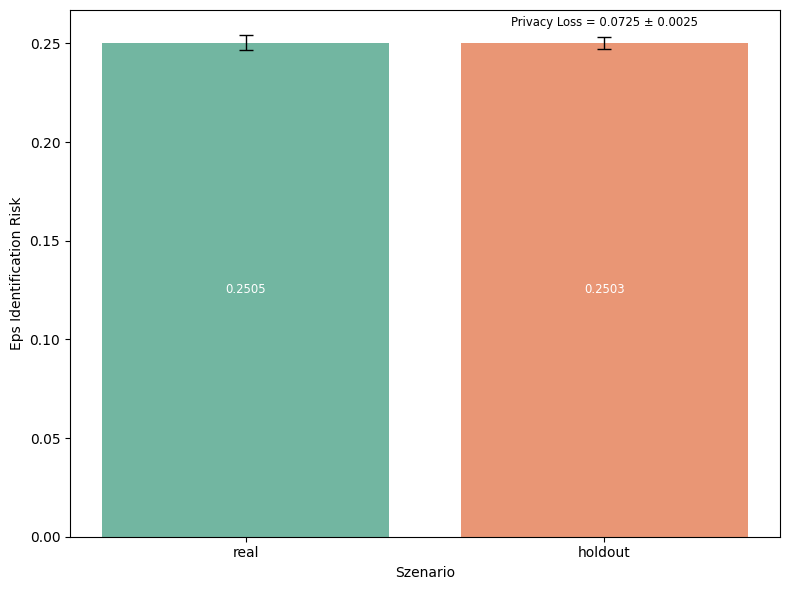

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))

# Barplot für eps_identif_risk
bars = sns.barplot(
    data=df_results,
    x='scenario',
    y='eps_identif_risk_val',
    errorbar=None,       # eigene Fehlerbalken
    palette='Set2',
    hue='scenario',
    ax=ax
)

# Fehlerbalken hinzufügen
ax.errorbar(
    x=np.arange(len(df_results)),
    y=df_results['eps_identif_risk_val'],
    yerr=df_results['eps_identif_risk_err'],
    fmt='none',
    capsize=5,
    linewidth=1,
    color='black'
)

# 1. Werte in den Bars (z.B. zentriert)
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # x-Position: Mitte der Bar
        height / 2,                     # y-Position: in der Bar-Mitte
        f"{height:.4f}",                # Label‐Text
        ha='center',
        va='center',
        fontsize='small',
        color='white'                   # passt gut auf dunklere Bars
    )

# 2. Privacy‐Loss‐Labels über den Balken mit Prefix
offset = df_results['eps_identif_risk_err'].max() * 1.1
for i, row in df_results.iterrows():
    pl_val = row['priv_loss_eps_val']
    pl_err = row['priv_loss_eps_err']
    if not np.isnan(pl_val):
        label = f"Privacy Loss = {pl_val:.4f} ± {pl_err:.4f}"
        ax.text(
            i,
            row['eps_identif_risk_val'] + row['eps_identif_risk_err'] + offset,
            label,
            ha='center',
            va='bottom',
            fontsize='small'
        )

ax.set_xlabel('Szenario')
ax.set_ylabel('Eps Identification Risk')
plt.tight_layout()

if save_data:
    plt.savefig(
        f'figures/Epsilon_Identif_Risk_{current_timestamp}.tiff',
        dpi=300, format='tiff', bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )

plt.show()


# Interpretation
- Allgemein: eps_risk >0.2: viele reale Datensätze können mit synthetischen verlinkt werden → Privacy-Risiko
- Privacy Loss $\approx0$: kein signifikanter Unterschied → gute Privacy
   - cave: Privacy Loss >=0.1 als Hinweis für Memorization (Yoon et al., 2020)
   - dennoch zeigen Privacy Loss-Werte >0 die Tendenz zur Trainingskopie

